# Perform phone segmentation in the notebook

Copyright (c) 2020 Herman Kamper, MIT License.

## Preliminaries

In [1]:
%matplotlib inline
from pathlib import Path
from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
import numpy as np
import pylab as plt
import sys

sys.path.append("..")

from eval_segmentation import boundaries_to_intervals, intervals_to_boundaries
from phoneseg_algorithms import get_segment_intervals, l2_segmentation, l2_n_segments, benji_l2_n_segments

## Read spectrograms, codes, segmentation

In [8]:
# Data set
dataset = "buckeye"
split = "val"
# model = "vqcpc"
model = "vqvae"

# Utterances
utterances = [
    "s22_02b_027666-027761",
    "s17_01a_001056-001166",
    ]

# Directories
indices_dir = Path("../exp/")/model/dataset/split/"indices"
z_dir = Path("../exp/")/model/dataset/split/"auxiliary_embedding2"
audio_dir = Path("../../VectorQuantizedCPC/datasets/")/dataset/split
phoneref_dir = Path("../data/")/dataset/"phone_intervals"

# Filenames
embedding_fn = Path("../exp/")/model/dataset/"embedding.npy"

In [9]:
# Embedding matrix
embedding = np.load(embedding_fn)

# Read indices
indices_dict = {}
for utterance_key in sorted(utterances):
    indices_fn = (indices_dir/utterance_key).with_suffix(".txt")
    indices_dict[utterance_key] = np.asarray(np.loadtxt(indices_fn), dtype=int)

# Read pre-quantisation
z_dict = {}
for utterance_key in sorted(utterances):
    z_fn = (z_dir/utterance_key).with_suffix(".txt")
    z_dict[utterance_key] = np.loadtxt(z_fn)

# Audio
audio_dict = {}
for utterance_key in sorted(utterances):
    fn = (audio_dir/utterance_key.split("_")[0]/utterance_key).with_suffix(".mel.npy")
    audio_dict[utterance_key] = np.load(fn).T
    
# Read reference
reference_interval_dict = {}
for utterance_key in sorted(utterances):
    reference_interval_dict[utterance_key] = []
    fn = (phoneref_dir/utterance_key).with_suffix(".txt")
    for start, end, label in [i.split() for i in fn.read_text().strip().split("\n")]:
        start = int(start)
        end = int(end)
        reference_interval_dict[utterance_key].append((start, end, label))

# Convert intervals to boundaries
reference_boundaries_dict = {}
for utterance_key in reference_interval_dict:
    reference_boundaries_dict[utterance_key] = intervals_to_boundaries(
        reference_interval_dict[utterance_key]
        )

## Plot codes on top of spectrograms

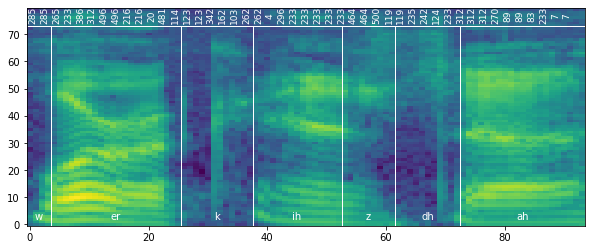

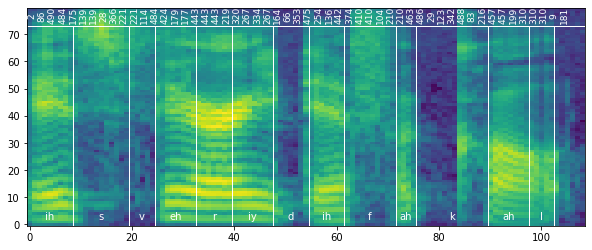

In [12]:
for utt_key in utterances:
    features = audio_dict[utt_key].T
    indices = indices_dict[utt_key]
    phones = reference_interval_dict[utt_key]

    # Codes
    plt.figure(figsize=(10, 4))
    plt.imshow(features, origin="bottom", aspect="auto", interpolation="nearest")
    for i in range(len(indices)):
        plt.text(i*2 + 0.5, features.shape[0] - 3, str(indices[i]), color="w", va="center", ha="center", rotation=90, size=9)
    plt.hlines(features.shape[0] - 7, -0.5, features.shape[1] - 0.5, colors="w", lw=1)

    # Reference
    for start, end, label in phones:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, 3, label, color="w", va="center", ha="center")
    plt.vlines(
        np.where(reference_boundaries_dict[utt_key])[0] + 0.5, ymin=-0.5, ymax=73, colors="w", lw=1
        )  # reference boundaries

## Developmental: Algorithms

In [5]:
def custom_viterbi_n_segments(costs, n_frames, n_segments):
    """
    Viterbi segmentation of an utterance of length `n_frames` based on `costs`
    constrained to produce `n_segments`.

    Parameters
    ----------
    costs : n_frames(n_frames + 1)/2 vector
        For t = 1, 2, ..., N the entries costs[i:i + t] contains the costs of
        seq[0:t] up to seq[t - 1:t], with i = t(t - 1)/2. Written out: costs =
        [cost(seq[0:1]), cost(seq[0:2]), cost(seq[1:2]), cost(seq[0:3]), ...,
        cost(seq[N-1:N])].

    Return
    ------
    (summed_cost, boundaries) : (float, vector of bool)
    """
    
    # Initialise
    boundaries = np.zeros(n_frames, dtype=bool)
    boundaries[-1] = True
    alphas = np.inf*np.ones((n_frames, n_segments + 1))
    alphas[0, 0] = 0.0

    # Forward filtering
    i = 0
    for t in range(1, n_frames):
        for s in range(1, n_segments):
            alphas[t, s] = np.min(
                costs[i:i + t] + alphas[:t, s - 1]
                )  # vectorise (?)
        i += t

#     print("alphas: {}".format(alphas))

    # Backward segmentation
    t = n_frames
    summed_cost = 0.0
    s = n_segments
    while True:
        i = int(0.5*(t - 1)*t)
        q_t_min_list = (
            costs[i:i + t] + alphas[:t, s - 1]
            )
        q_t_min_list = q_t_min_list[::-1]
        q_t = np.argmin(q_t_min_list) + 1

        # print("-"*39)
        # print("t = {}".format(t))
        # print("q_t_min_list: {}".format(q_t_min_list))
        # print("arg min: {}".format(q_t))
        # print("Cost: {:.4f}".format(costs[i + t - q_t]))
        
        summed_cost += costs[i + t - q_t]
        if t - q_t - 1 < 0:
            break
        boundaries[t - q_t - 1] = True
        t = t - q_t
        s -= 1

    # print("Utterance loss: {:.4f}".format(summed_cost))
    return summed_cost, boundaries

In [73]:
def l2_n_segments(embedding, z, n_frames_per_segment=7, n_min_frames=0, n_max_frames=15,
        dur_weight=0, **kwargs):
    
    # Hyperparameters
    n_segments = max(1, int(round(z.shape[0]/n_frames_per_segment)))
    assert n_max_frames*n_segments >= z.shape[0]
    n_segments = 4  # temp

    # Distances between each z and each embedding (squared Euclidean)
    embedding_distances = distance.cdist(z, embedding, metric="sqeuclidean")
    
    # Costs for segment intervals
    segment_intervals = get_segment_intervals(z.shape[0], n_max_frames)
    costs = np.inf*np.ones(len(segment_intervals))
    for i_seg, interval in enumerate(segment_intervals):
        if interval is None:
            continue
        i_start, i_end = interval
        dur = i_end - i_start
        if dur < n_min_frames:
            continue
        cost = np.min(
            np.sum(embedding_distances[i_start:i_end, :], axis=0)
            ) - dur_weight*(dur - 1)
        costs[i_seg] = cost
    
    # Viterbi segmentation
    summed_cost, boundaries = custom_viterbi_n_segments(costs, z.shape[0], n_segments)
    
    # Code assignments
    segmented_codes = []
    j_prev = 0
    for j in np.where(boundaries)[0]:
        i_start = j_prev
        i_end = j + 1
        code = np.argmin(np.sum(embedding_distances[i_start:i_end, :], axis=0))
        segmented_codes.append((i_start, i_end, code))
        j_prev = j + 1
    
    return boundaries, segmented_codes


def benji_l2_n_segments(embedding, z, n_frames_per_segment=7):

    # Hyperparameters
    n_segments = max(1, int(round(z.shape[0]/n_frames_per_segment)))
    n_segments = 4  # temp

    # Distances between each z and each embedding (squared Euclidean)
    dists = distance.cdist(z, embedding, metric="sqeuclidean")
    
    # Initialise cost and history tensors
    T, K, S = z.shape[0], embedding.shape[0], n_segments  # sequence length, codes, segments
    alphas = np.zeros((T, K, S))                          # costs
    q = np.zeros((T, K, S), np.int)                       # history
    alphas[0, :, 0] = dists[0, :]
    alphas[0, :, 1:] = np.inf
    
    # Dynamic programming (unvectorised)
#     for t in range(1, T):
#         for k in range(K):
#             for s in range(S):
#                 if s > 0:
#                     ind = np.argmin(alphas[t - 1, :, s - 1])
#                     alphas[t, k, s] = dists[t, k] + min(alphas[t - 1, k, s], alphas[t - 1, ind, s - 1])
#                     q[t, k, s] = ind if alphas[t - 1, ind, s - 1] < alphas[t - 1, k, s] else k
#                 else:
#                     alphas[t, k, s] = dists[t, k] + alphas[t - 1, k, s]
#                     q[t, k, s] = k
#     codes = np.zeros(T, dtype=np.int)
#     codes[-1] = np.argmin(alphas[-1, :, -1])
#     s = S - 1
#     for t in range(T - 1, 0, -1):
#         codes[t - 1] = q[t, codes[t], s]
#         if codes[t - 1] != codes[t]:
#             s -= 1

    # Dynamic programming (vectorised)
    for t in range(1, T):
        ind = np.argmin(alphas[t - 1, :, :-1], axis=0)
        alphas[t, :, 1:] = dists[t, :, None] + np.minimum(alphas[t - 1, :, 1:], alphas[t - 1, ind, np.arange(S - 1)])
        q[t, :, 1:] = np.where(alphas[t - 1, ind, np.arange(S - 1)] < alphas[t - 1, :, 1:], ind[None, :], np.arange(K)[:, None])
        alphas[t, :, 0] = dists[t, :] + alphas[t - 1, :, 0]
        q[t, :, 0] = np.arange(K)
    codes = np.zeros(T, dtype=np.int)
    codes[-1] = np.argmin(alphas[-1, :, -1])
    s = S - 1
    for t in range(T - 1, 0, -1):
        codes[t - 1] = q[t, codes[t], s]
        if codes[t - 1] != codes[t]:
            s -= 1
    
#     print(codes)
            
    # Boundaries and code assignments
    boundaries = np.zeros(z.shape[0], dtype=bool)
    segmented_codes = []
    prev_code = codes[0]
    prev_boundary = 0
    for i, code in enumerate(codes[1:]):
        if code != prev_code:
            boundaries[i] = True
            segmented_codes.append((prev_boundary, i + 1, prev_code))
            prev_boundary = i + 1
        prev_code = code
    if codes[-1] != prev_code:
        boundaries[i + 1] = True
    boundaries[-1] = True  # final position is always boundary
    segmented_codes.append((prev_boundary, z.shape[0], prev_code))
    
    return boundaries, segmented_codes
    

## Segment and plot segmentation

In [8]:
# Segmentation

downsample_factor = 2

boundaries_dict = {}
code_indices_dict = {}
for utt_key in utterances[:1]:
    
    # Segment
    z = z_dict[utt_key]
#     boundaries, code_indices = l2_segmentation(embedding, z, dur_weight=50**2)
#     boundaries, code_indices = l2_segmentation(embedding, z, dur_weight=25**2)
    boundaries, code_indices = l2_n_segments(embedding, z, n_frames_per_segment=7, n_max_frames=z.shape[0])
#     boundaries, code_indices = benji_l2_n_segments(embedding, z, n_frames_per_segment=7)

    print(code_indices)

    # Convert boundaries to same frequency as reference
    if downsample_factor > 1:
        boundaries_upsampled = np.zeros(
            len(boundaries)*downsample_factor, dtype=bool
            )
        for i, bound in enumerate(boundaries):
            boundaries_upsampled[i*downsample_factor + 1] = bound
        boundaries = boundaries_upsampled

        code_indices_upsampled = []
        for start, end, index in code_indices:
            code_indices_upsampled.append((
                start*downsample_factor, 
                end*downsample_factor,
                index
                ))
        code_indices = code_indices_upsampled

    boundaries_dict[utt_key] = boundaries_upsampled
    code_indices_dict[utt_key] = code_indices

[(0, 5, 46), (5, 13, 479), (13, 22, 164), (22, 29, 501), (29, 37, 164), (37, 46, 87), (46, 47, 427)]


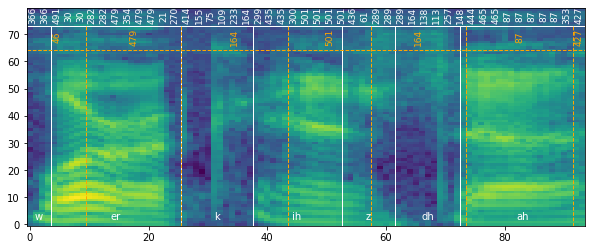

In [9]:
for utt_key in utterances[:1]:
    features = audio_dict[utt_key].T
    indices = indices_dict[utt_key]
    phones = reference_interval_dict[utt_key]

    # Codes
    plt.figure(figsize=(10, 4))
    plt.imshow(features, origin="bottom", aspect="auto", interpolation="nearest")
    for i in range(len(indices)):
        plt.text(i*2 + 0.5, features.shape[0] - 3, str(indices[i]), color="w", va="center", ha="center", rotation=90, size=9)
    plt.hlines(features.shape[0] - 7, -0.5, features.shape[1] - 0.5, colors="w", lw=1)

    # Reference
    for start, end, label in phones:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, 3, label, color="w", va="center", ha="center")
    plt.vlines(
        np.where(reference_boundaries_dict[utt_key])[0] + 0.5, ymin=-0.5, ymax=73, colors="w", lw=1
        )  # reference boundaries

    # Segmentation
    c = "orange"
    for start, end, label in code_indices_dict[utt_key]:
        mid_frame = start + (end - start)/2.0
        plt.text(mid_frame - 0.5, features.shape[0] - 11, label, color=c, va="center", ha="center", rotation=90, size=9)
    plt.vlines(
        np.where(boundaries_dict[utt_key][:-1])[0] + 0.5, ymin=-0.5, ymax=features.shape[0] - 7, colors=c, lw=1, linestyles="dashed"
        )  # predicted boundaries
    plt.hlines(features.shape[0] - 16, -0.5, features.shape[1] - 0.5, colors=c, lw=1, linestyles="dashed")
    